In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

import plotly.express as px

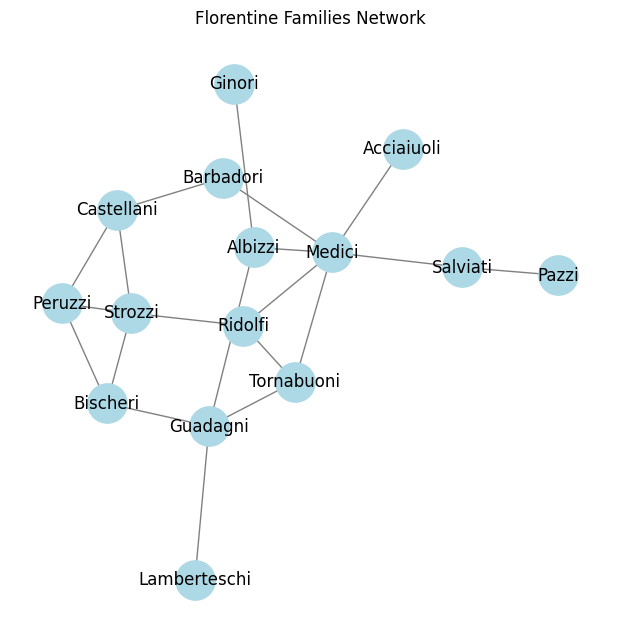

In [5]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

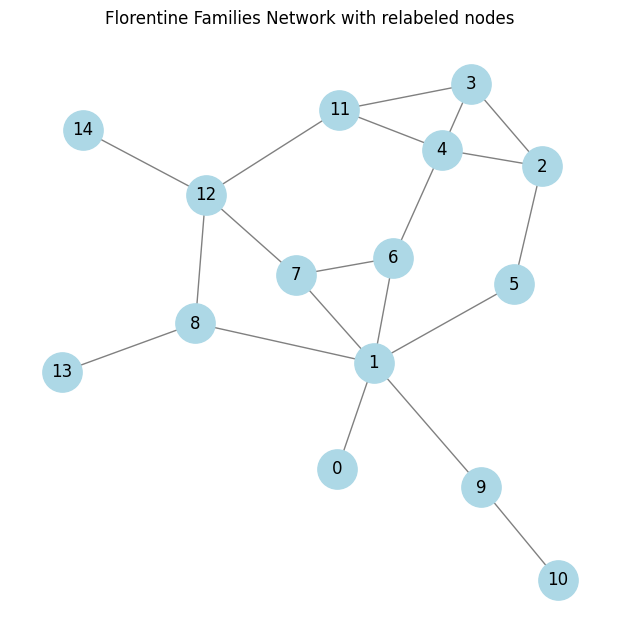

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [6]:
G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

[]

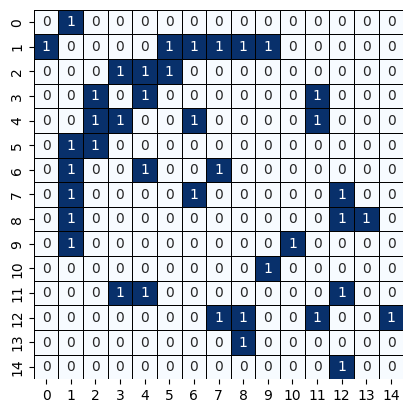

In [7]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=True, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='black')
plt.plot()

# Latent space

In [8]:
n = len(G.nodes)

inclination_angles = np.pi*np.random.rand(n)
azimutal_angles = 2*np.pi*np.random.rand(n)

x = np.sin(inclination_angles) * np.cos(azimutal_angles)
y = np.sin(inclination_angles) * np.sin(azimutal_angles)
z = np.cos(inclination_angles)
Z = np.stack((x, y, z), axis=1)


df = pd.DataFrame(Z, columns=['x', 'y', 'z'])
df['node'] = df.index 
df['inclination_angle'] = inclination_angles
df['azimutal_angle'] = azimutal_angles

# Graficar
fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    color_discrete_sequence=["blue"],  # mismo color para todos
    opacity=0.7,
    hover_data={
        'node': True,
        'inclination_angle': ':.2f',    # mostrar ángulos con dos decimales
        'azimutal_angle': ':.2f',
        'x': ':.2f',
        'y': ':.2f',
        'z': ':.2f'
    }
)

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
        aspectmode='cube'
    ),
    title="Initialization of nodes in 3D space",
)

fig.show()

# Likelihood

In [9]:
def loglikelihood(Z,a):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            d = np.arccos(np.clip(Z[i].T @ Z[j], -1.0, 1.0))/ (1*np.pi)
            eta = a * (1 - d)
            if j in G.neighbors(i):
                total += eta * 1  + (-np.logaddexp(0, eta))
            elif j != i:
                total += (-np.logaddexp(0, eta))
    return total

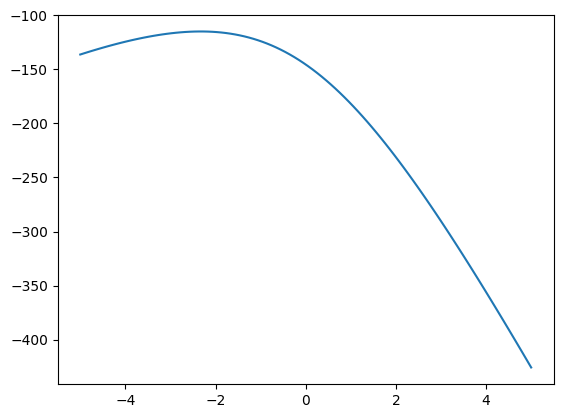

In [10]:
plt.plot(np.linspace(-5,5,100),[loglikelihood(Z,t) for t in np.linspace(-5,5,100)])
plt.show()

In [11]:
def grad_loglikelihood(Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = np.arccos(np.clip(Z[i].T @ Z[j], -1.0, 1.0))/ (1*np.pi)
                eta = a* ( 1 - dist )
                grad_Z[i,:] +=  (y-expit(eta)) * (-a) * (-1/(2*np.pi)) * Z[j] / np.sqrt(1 - (np.clip(Z[i].T @ Z[j],-0.999,0.999))**2)
                grad_a += (y-expit(eta)) * (1 - dist) 
    return grad_Z, grad_a

In [12]:
def update_Z(Z, grad_Z):
    for i in range(len(Z)):
        proj_orth = grad_Z[i]-np.dot(Z[i], grad_Z[i]) * Z[i]
        Z[i] = Z[i] + proj_orth 
        Z[i] = Z[i] / np.linalg.norm(Z[i])
    return Z

-148.52999456854974
-144.07071789454562


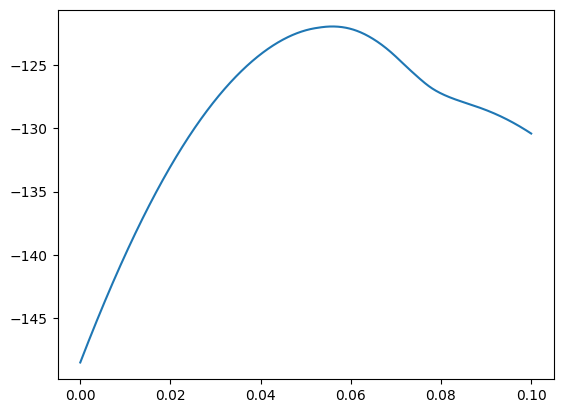

In [13]:
grad_Z,  grad_a = grad_loglikelihood(Z,0.1)
lr = 0.005
print(loglikelihood(Z,0.1))
print(loglikelihood(update_Z(Z, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(update_Z(Z, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Searching MLE

In [14]:
def SearchingMLE(Z_init, a_init, tol=1e-2, max_iter=100, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]
    
    for i in range(max_iter):
        grad_Z,  grad_a = grad_loglikelihood(Z0,a0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(update_Z(Z0, alpha*grad_Z) ,a0 + alpha*grad_a) < loglikelihood(Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
            if alpha < 1e-4:
                alpha = 0.0
                break
        
        # Update step
        Z0 = update_Z(Z0, alpha*grad_Z) 
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)
    
    return  Z0, a0, historyZ, historya

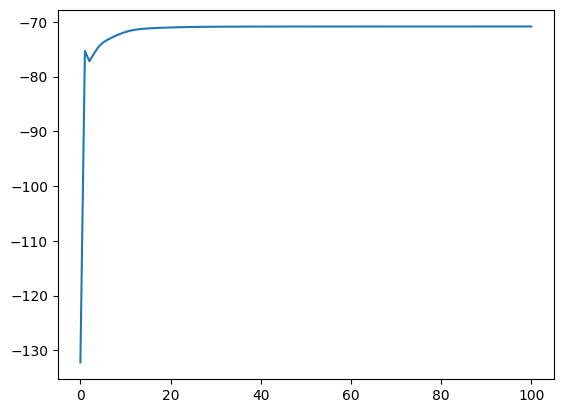

Initial log-likelihood: -118.95501857187091
Final log-likelihood: -70.84868630268097


In [15]:
inclination_angles_rand = np.pi*np.random.rand(n)
azimutal_angles_rand = 2*np.pi*np.random.rand(n)

Z_init_MLE = np.stack((np.sin(inclination_angles_rand) * np.cos(azimutal_angles_rand),
                       np.sin(inclination_angles_rand) * np.sin(azimutal_angles_rand),
                       np.cos(inclination_angles_rand)), axis=1)
a_init_MLE = np.random.randn()
Z_ML, a_ML, historyZ, historya  =  SearchingMLE(Z_init_MLE ,np.random.randn())
plt.plot([loglikelihood(historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

print("Initial log-likelihood:", loglikelihood(Z_init_MLE,a_init_MLE))
print("Final log-likelihood:", loglikelihood(Z_ML,a_ML))

In [16]:
df = pd.DataFrame(Z_ML, columns=['x', 'y', 'z'])
df['node'] = df.index 
df['inclination_angle'] = inclination_angles
df['azimutal_angle'] = azimutal_angles

# Graficar
fig = px.scatter_3d(
    df,
    x='x',
    y='y',
    z='z',
    color_discrete_sequence=["blue"],  # mismo color para todos
    opacity=0.7,
    hover_data={
        'node': True,
        'inclination_angle': ':.2f',    # mostrar ángulos con dos decimales
        'azimutal_angle': ':.2f',
        'x': ':.2f',
        'y': ':.2f',
        'z': ':.2f'
    }
)

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
        aspectmode='cube'
    ),
    title="ML estimation of nodes in 3D space",
)

fig.show()

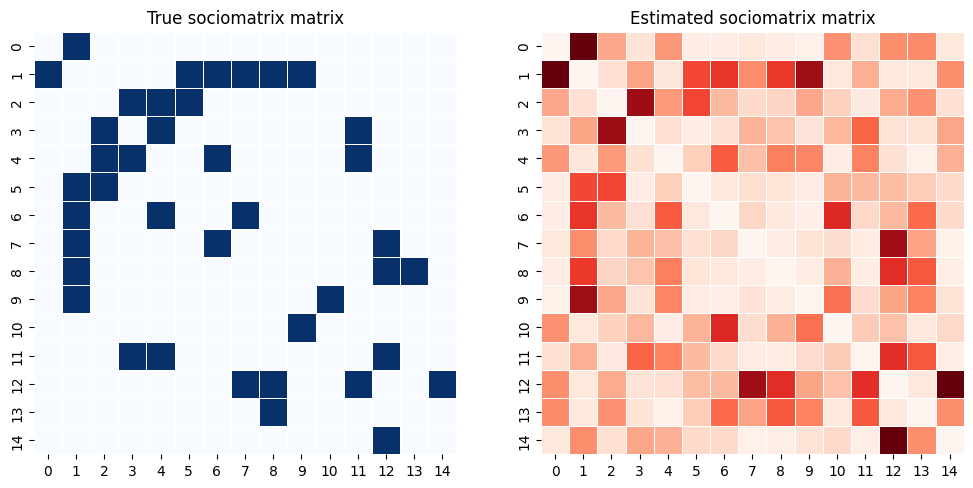

In [17]:
Y_MLE = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = np.arccos(np.clip(Z_ML[i].T @ Z_ML[j], -1.0, 1.0))/ (1*np.pi)
            Y_MLE[i,j] = expit(a_ML * (1 - d))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_MLE, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

# Prior distribution

In [18]:
def logpriori(Z,a,var=1):
    logpriorZ = 0.0
    for i in range(len(Z)):
        logpriorZ += np.log(0.1 - (Z[i].T @ Z[i] -1)**2)/10
    logpriora = 0.5 * a**2 / var
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + logpriorZ + logpriora)

In [19]:
logpriori(Z_ML,a_ML)

np.float64(-21.59967909720531)

In [20]:
def grad_logpriori(Z,a,var=1):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = (4/10) * Z[i] * (Z[i].T @ Z[i] -1) / (0.1 - (Z[i].T @ Z[i] -1)**2)
    grad_a = (-1) * a / var  
    return grad_Z, grad_a

-11.254138891783695
-11.249138891783694


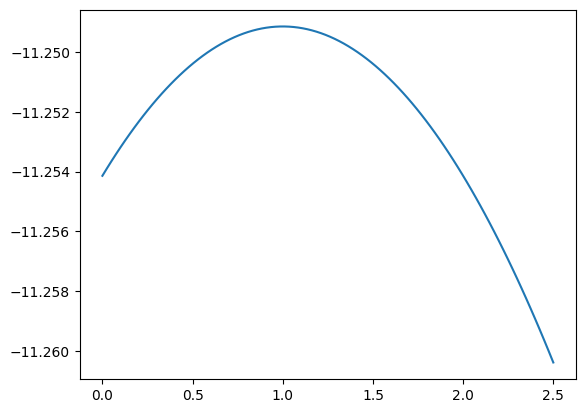

In [21]:
grad_Z,  grad_a = grad_logpriori(Z,0.1)
lr = 1.0
print(logpriori(Z,0.1))
print(logpriori(update_Z(Z, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,2.5,100),[logpriori(update_Z(Z, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,2.5,100)])
plt.show()

# Potential Energy

In [22]:
def U(Z,a,var=1):
    return (-1) * (loglikelihood(Z,a) + logpriori(Z,a,var))

def grad_U(Z,a,var=1):
    grad_Z_likelihood, grad_a_likelihood = grad_loglikelihood(Z,a)
    grad_Z_priori, grad_a_priori = grad_logpriori(Z,a,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    return -grad_Z, -grad_a

159.41443278289597
137.06090541260258


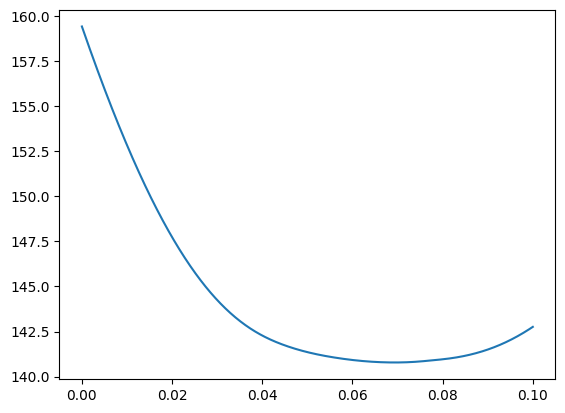

In [23]:
grad_Z,  grad_a = grad_U(Z,0.1)
lr = 0.06
print(U(Z,0.1))
print(U(update_Z(Z, -lr*grad_Z),0.1 - lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[U(update_Z(Z, -lr*grad_Z),0.1-lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [24]:
def project_to_tangent_space(theta, phi):
    return phi - np.dot(phi, theta) * theta
def geodesic_flow(theta, phi, step_size):
    alpha = np.linalg.norm(phi)
    if alpha > 1e-10:
        new_theta = theta * np.cos(alpha * step_size) + (phi / alpha) * np.sin(alpha * step_size)
        new_phi = phi * np.cos(alpha * step_size) - alpha * theta * np.sin(alpha * step_size)
    else:
        new_theta, new_phi = theta, phi  # Evita división por cero
    return new_theta, new_phi

In [25]:
def compute_star(Old, Ref):
    inclination_ang_old = np.arctan2(Old[:,1], Old[:,0])
    azimutal_ang_old = np.arccos(Old[:,2])
    inclination_ang_ref = np.arctan2(Ref[:,1], Ref[:,0])
    azimutal_ang_ref = np.arccos(Ref[:,2])
    
    
    addition_inclination = np.mean(inclination_ang_ref - inclination_ang_old)
    addition_inclination = np.mean(azimutal_ang_ref - azimutal_ang_old)
    
    inclination_ang_new = inclination_ang_old + addition_inclination
    azimutal_ang_new = azimutal_ang_old + addition_inclination
    New = np.zeros_like(Old)
    New[:,0] = np.cos(azimutal_ang_new) * np.sin(inclination_ang_new)
    New[:,1] = np.sin(azimutal_ang_new) * np.sin(inclination_ang_new)
    New[:,2] = np.cos(inclination_ang_new)
    return New 

In [26]:
compute_star(Z,Z_ML)

array([[ 0.05060253, -0.7806957 , -0.62285921],
       [-0.44834172, -0.83569494, -0.31718081],
       [-0.25944373,  0.9443671 , -0.20213791],
       [ 0.36544495,  0.91420421,  0.17515894],
       [ 0.8398699 ,  0.49258973,  0.22797788],
       [ 0.62050765, -0.76719172, -0.1624411 ],
       [-0.1765138 , -0.12824652, -0.97590763],
       [-0.07068768, -0.07284938, -0.99483477],
       [-0.54684885, -0.8135616 , -0.19767106],
       [ 0.66495331, -0.28635765, -0.68980895],
       [-0.06078608,  0.06483468, -0.99604293],
       [ 0.8910385 ,  0.3439905 ,  0.2961772 ],
       [-0.23213969,  0.02238134, -0.97242493],
       [ 0.70829424, -0.69102189, -0.14424988],
       [ 0.06236492,  0.51081896, -0.85742324]])

In [31]:
def ghmc(Z_init, a_init, num_samples, epsilon_init=0.05, std_dev_init=1.0, warmup=125):
    samples_Z = [Z_init]
    samples_a = [a_init]
    Hamiltonian_p = [U(Z_init,a_init)]

    Z = Z_init.copy()
    a = a_init.copy()

    # Parámetros adaptativos
    epsilon = epsilon_init
    std_dev = std_dev_init
    L = max(1, int(round(1/epsilon)))  # L = 1/ε
    accept_count = 0
    total_updates = 0

    acep_rate_history = np.zeros(num_samples)
    
    for iter in tqdm(range(num_samples)):

        # Adaptación de parámetros
        adapting = iter < warmup
        if adapting and iter > 0 and iter % 1 == 0:
            # Ajustar epsilon basado en tasa de aceptación reciente
            current_accept_rate = accept_count / total_updates if total_updates > 0 else 0
            if current_accept_rate < 0.65:
                epsilon *= 0.95 
                std_dev *= 0.90
            elif current_accept_rate > 0.85:
                epsilon *= 1.05  # Aumentar epsilon si aceptación es alta
                std_dev *= 1.10
            L = max(1, int(round(1/epsilon)))  # Actualizar L



        grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])


        ### HMC algorithm for Z

        for i in range(Z.shape[0]):
            grad_Z_i = grad_Z[i].copy()
            Z_i = Z[i].copy()
            
            p_i = np.random.normal(0, std_dev, size=Z_i.shape)
            p_i = project_to_tangent_space(Z_i, p_i)
            current_p = p_i.copy()
            #Leapfrog integration
            p_i -= epsilon * grad_Z_i / 2 
            p_i = project_to_tangent_space(Z_i, p_i)       
            for _ in range(L):
                Z_i, p_i = geodesic_flow(Z_i, p_i, epsilon)
            Z[i] = Z_i.copy()
            grad_Z,  grad_a = grad_U(Z,samples_a[-1])
            grad_Z_i = grad_Z[i].copy()
            p_i -= epsilon * grad_Z_i / 2
            p_i = project_to_tangent_space(Z_i, p_i)
            

            # Hamiltonian
            current_U = U(samples_Z[-1],samples_a[-1])
            current_K = 0.5 * np.sum(current_p**2)
            current_H = current_U + current_K
            proposed_U = U(Z,samples_a[-1])
            proposed_K = 0.5 * np.sum(p_i**2)
            proposed_H = proposed_U + proposed_K
            # Metropolis-Hastings acceptance rate
            log_accept_ratio = current_H - proposed_H
            if log_accept_ratio > 0:
                Z_C = compute_star(Z,Z_ML)
                samples_a.append(samples_a[-1])
                samples_Z.append(Z_C.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
            elif np.random.rand() < np.exp(log_accept_ratio):
                Z_C = compute_star(Z,Z_ML)
                samples_a.append(samples_a[-1])
                samples_Z.append(Z_C.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
            else:
                samples_a.append(samples_a[-1])
                samples_Z.append(samples_Z[-1])
                Hamiltonian_p.append(current_H)
            total_updates += 1   

            grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])

        

        ### HMC algorithm for a
        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p
            grad_Z,  grad_a = grad_U(samples_Z[-1],a)
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1])
        current_K = 0.5 * np.sum(current_p**2)
        current_H = current_U + current_K

        proposed_U = U(samples_Z[-1],a)
        proposed_K = 0.5 * np.sum(p**2)
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H
        if log_accept_ratio > 0:
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
        elif np.random.rand() < np.exp(log_accept_ratio):
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
        else:
            samples_a.append(samples_a[-1])
            samples_Z.append(samples_Z[-1])
            Hamiltonian_p.append(current_H)
        total_updates += 1    
        acep_rate_history[iter] = accept_count / total_updates if total_updates > 0 else 0
    aceptance_rate = accept_count / total_updates
    print(f"Acceptance rate: {aceptance_rate:.5f}")
    print(f"Final parameters: epsilon={epsilon:.4f}, L={L}, std_dev={std_dev:.4f}")
    samples_Z = np.array(samples_Z)
    samples_a = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_a]
    Hamiltonian_p = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in Hamiltonian_p]
    return samples_Z, samples_a, Hamiltonian_p, acep_rate_history

In [42]:
inclination_angles_rand = np.pi*np.random.rand(n)
azimutal_angles_rand = 2*np.pi*np.random.rand(n)

Z1 = np.stack((np.sin(inclination_angles_rand) * np.cos(azimutal_angles_rand),
                       np.sin(inclination_angles_rand) * np.sin(azimutal_angles_rand),
                       np.cos(inclination_angles_rand)), axis=1)
a1 = np.float64(np.random.randn())

print("Log-L MLE:", loglikelihood(Z_ML,a_ML))
print("Log-L starter:", loglikelihood(Z1,a1))

Log-L MLE: -70.84868630268097
Log-L starter: -169.84093809883785


In [41]:
np.min(1,2)

AxisError: axis 2 is out of bounds for array of dimension 0

In [38]:
# Execute HMC
samples_Z, samples_a, Hp, acep_rate_history = ghmc(Z1, a1, 100, epsilon_init=0.1, std_dev_init=0.5, warmup=100)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]

100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

Acceptance rate: 0.26875
Final parameters: epsilon=0.0022, L=447, std_dev=0.0002


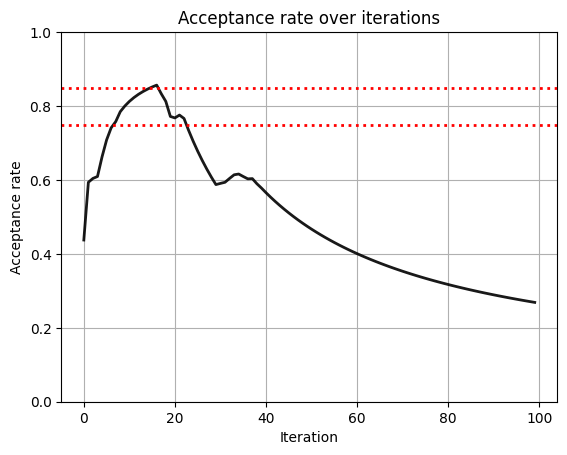

In [39]:
plt.plot(acep_rate_history, color='black', alpha=0.9, linewidth=2)
plt.axhline(0.85, color='red', linestyle=':', linewidth=2, label='')
plt.axhline(0.75, color='red', linestyle=':', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Acceptance rate")
plt.title("Acceptance rate over iterations")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

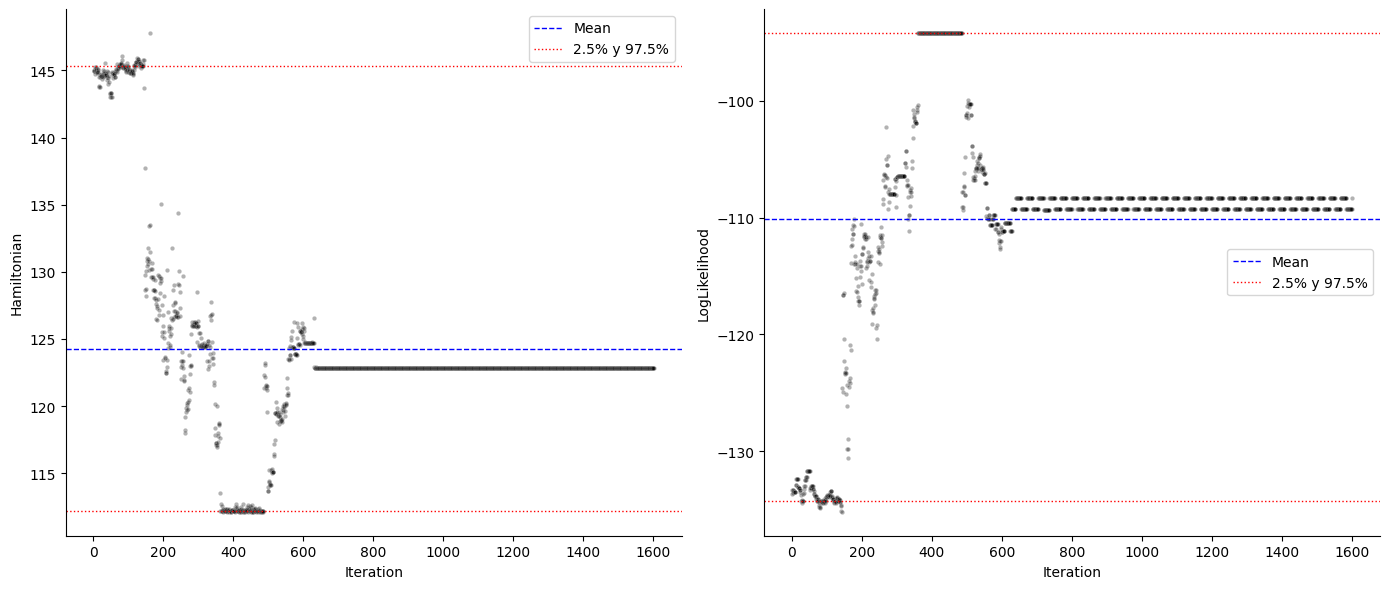

In [40]:
# 
x1 = Hp
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({
    'Iteration': iterations1,
    'LogLikelihood': x1
})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

# 
x2 = [np.float64(loglikelihood(samples_Z[i],samples_a[i]))for i in range(1,len(samples_a))]
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({
    'Iteration': iterations2,
    'LogLikelihood': x2
})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

#
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

# 
sns.scatterplot(ax=axs[0], x='Iteration', y='LogLikelihood', data=data1, color='black', alpha=0.3, s=10)
axs[0].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[0].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[0].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Hamiltonian")
axs[0].legend()


#
sns.scatterplot(ax=axs[1], x='Iteration', y='LogLikelihood', data=data2, color='black', alpha=0.3, s=10)
axs[1].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("LogLikelihood")
axs[1].legend()

sns.despine()
plt.tight_layout()
plt.show()
